In [ ]:
!pip install foolbox
!pip install GPUtil
!pip install facenet-pytorch
!pip install faiss-gpu

from facenet_pytorch import MTCNN, InceptionResnetV1

from GPUtil import showUtilization as gpu_usage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os 
import numpy as np
from sklearn import metrics

import torch.tensor as TorchTensor
import torchvision.models as models
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples
import torch

from torchvision import datasets
from torch.utils.data import DataLoader
from sklearn.preprocessing import normalize
import tqdm
import torchvision.transforms as transforms
pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()
from scipy.spatial.distance import pdist, squareform
from foolbox.attacks import FGSM
from scipy.spatial.distance import cosine
import faiss
from sklearn.metrics import accuracy_score
from facenet_pytorch import MTCNN, InceptionResnetV1
import cv2
import time


def get_num(num):
    if len(num)==1:
        num = '000'+num
    elif len(num)==2:
        num= '00'+num
    elif len(num)==3:
        num = '0'+num
    return(num+'.jpg')
def plot_image(tensor):
    # plt.figure()
    # imshow needs a numpy array with the channel dimension
    # as the the last dimension so we have to transpose things.
    plt.imshow(tensor.numpy().transpose(1, 2, 0),)
    # plt.show()
def get_gaussian_blur(data, kernel=(5,5), sigmaX=0,sigmaY=0):
  
  img = cv2.GaussianBlur(data,kernel,sigmaX=sigmaX,sigmaY = sigmaY )
  return(img)
def tf_shape2PT_shape(data):#(160,160,3)
  return(data.swapaxes(0,2).swapaxes(2,1))# (3,160,160)
def PT_shape2TF_shape(data):#(3,160,160)
  return(data.swapaxes(0,2).swapaxes(0,1))#(160,160,3)

     |████████████████████████████████| 1.7MB 6.5MB/s 
     |████████████████████████████████| 460kB 44.0MB/s 
     |████████████████████████████████| 71kB 9.6MB/s 
ERROR: chainer 6.5.0 has requirement typing-extensions<=3.6.6, but you'll have typing-extensions 3.7.4.2 which is incompatible.
  Found existing installation: typing-extensions 3.6.6
    Uninstalling typing-extensions-3.6.6:
      Successfully uninstalled typing-extensions-3.6.6
  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=1a31801985dbd0edca41272ac916083ba48bb3f639beb49fddaf33e2feabcbd1
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil
     |████████████████████████████████| 1.9MB 6.2MB/s 
     |████████████████████████████████| 35.5MB 89kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/ВКР

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
workers = 0 if os.name == 'nt' else 4
print('Running on device: {}'.format(device))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/ВКР
Running on device: cuda


In [ ]:
#http://vis-www.cs.umass.edu/lfw/peopleDevTrain.txt
resnet = InceptionResnetV1(pretrained='vggface2').eval()

In [ ]:
with open('Dataset/pairs.txt','r') as f:
    names = f.readlines()[1:]

In [ ]:
pairs = []
dir_ = 'Dataset/lfw_cropped/'
labels = []
for name in names:
    parts = name.split('\t')
    if len(parts)==3:
        parts[1] = get_num(parts[1])
        name1 = dir_+parts[0]+'/'+parts[0]+'_'+parts[1]# 'Arman_Hakobyan_0001.jpg'
        parts[2] = get_num(parts[2].replace('\n',''))
        name2 = dir_+parts[0]+'/'+parts[0]+'_'+parts[2]# 'Arman_Hakobyan_0002.jpg'        
        labels.append(1)
    elif len(parts)==4:
        parts[1] = get_num(parts[1])
        name1 = dir_+parts[0]+'/'+parts[0]+'_'+parts[1]
        parts[3] = get_num(parts[3].replace('\n',''))
        name2 = dir_+parts[2]+'/'+parts[2]+'_'+parts[3]
        labels.append(0)
    pairs.append([name1,name2])


In [ ]:
%%time
data = []
for pair in tqdm.tqdm_notebook(pairs):
    pair_img = []
    for single in pair:        
        img = Image.open(single)
        pair_img.append(pil2tensor(img))
    pair_img = list(map(torch.Tensor.numpy,pair_img))
    pair_img = np.array(pair_img)
    
    data.append(pair_img)
    
data = np.array(data)
# torch.save(data, 'Dataset/lfw_pairs.pt')
# np.savez("Dataset/lfw_pairs", data)
# data = np.load("Dataset/lfw_pairs.npz")['arr_0'] #make sure you use the .npz!

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
data = np.load("Dataset/lfw_pairs.npz")['arr_0']
data = torch.tensor(data)
data.shape

torch.Size([6000, 2, 3, 160, 160])

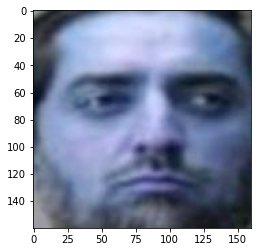

In [ ]:
advs = torch.load('Dataset/adversarial_pgd_004_pair_data100.pt')
img = cv2.imread('Dataset/Armen_Arman_cropped/Abdullah/Abdullah_0001.jpg')

plt.imshow(img)

Dataset/lfw_cropped/Abel_Pacheco/Abel_Pacheco_0001.jpg


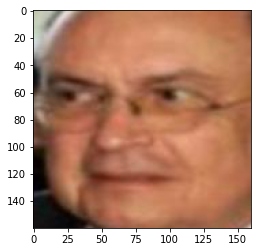

In [ ]:
print(pairs[0][0])
plot_image(data[0][0])

In [ ]:
def get_embddings(data):#shape (6000,2,3,160,160)
  embeddings = []
  for pair in tqdm.tqdm_notebook(data):
    emb = resnet(pair.reshape(2,3,160,160)).detach().cpu()
    embeddings.append(emb)
  embeddings = torch.stack(embeddings)
  return(embeddings)

def get_cosin_dists(embeddings):
  D = []
  for embedd in tqdm.tqdm_notebook(embeddings):
    d = 1-cosine(normalize(embedd[0].reshape(1,512)), normalize(embedd[1].reshape(1,512)))
    D.append(d)
  return(D)

## create adversarial examples

In [ ]:
!pip install facenet-pytorch
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image

# For a model pretrained on VGGFace2
model = InceptionResnetV1(pretrained='vggface2').eval()
# For a model pretrained on CASIA-Webface
model = InceptionResnetV1(pretrained='casia-webface').eval()

#read image 
img = Image.open(<image path>)
#cropped image 
mtcnn  =  MTCNN(image_size=<image_size>, margin=<margin>)
# Get cropped and prewhitened image tensor
img_cropped = mtcnn(img)
# Calculate embedding (unsqueeze to add batch dimension)
img_embedding = resnet(img_cropped.unsqueeze(0))


In [ ]:
data.shape
from foolbox.attacks import PGD
attack = PGD()
# attack = FGSM()

In [ ]:
fmodel = PyTorchModel(resnet,bounds=(0,1))

In [ ]:
del resnet

In [ ]:
new = []
for pair in pairs:
  new.extend(pair)
onli_names = list(map(lambda x:x.split('/')[2],new))
replace_dict = {onli_names[i]:i for i in range(len(onli_names))}
# label_num = list(map(lambda x:replace_dict[x], n))

code_pairs=[]
for pair in pairs:
  code_pair=[]
  for k in pair:    
    nm = k.split('/')[2]
    code = replace_dict[nm]
    code_pair.append(code)
  code_pairs.append(torch.Tensor(code_pair))
code_pairs = torch.stack(code_pairs).long().to(device)


In [ ]:
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  6% |  4% |


In [ ]:
del fmodel,data

In [ ]:
def reshape_and_blur(data, kernel=(3,3),sigmaX=3,sigmaY=0):
  d = PT_shape2TF_shape(data)
  d = get_gaussian_blur(d,kernel =kernel,sigmaX=sigmaX,sigmaY=sigmaY)
  d =tf_shape2PT_shape(d)
  return(d)
  

In [ ]:
%%time
advs=[]
for batch,Y in tqdm.tqdm_notebook(zip(torch.split(data.reshape(12000,3,160,160).to(device),20), torch.split(code_pairs.reshape(12000,).to(device),20) )):
  adv, _,_= attack(fmodel, batch, Y,epsilons =0.05)
  adv = adv.detach().cpu().numpy()
  if True:#get gaussin blure with kernel (5,5)
    adv = torch.tensor(list(map(reshape_and_blur,adv)))
  advs.append(torch.tensor(adv))
# torch.save(advs[:50], 'Dataset/adversarial_pgd_004_pair_data.pt')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys



CPU times: user 1h 12min 7s, sys: 32min 51s, total: 1h 44min 59s
Wall time: 1h 45min 31s


In [ ]:
# del data, fmodel,adv, batch,Y,attack
# time.sleep(20)
advs = torch.stack(advs)
advs = advs.reshape(12000,3,160,160).reshape(6000,2,3,160,160)
advs = advs.to(device)

In [ ]:
advs.shape

torch.Size([6000, 2, 3, 160, 160])

In [ ]:
x = advs[:10].cpu().numpy()
np.savez("Dataset/unti_pgd005_gaus3_sigmax3_pairs", x)

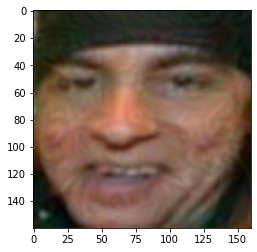

In [ ]:
plot_image(advs[330][1].cpu())

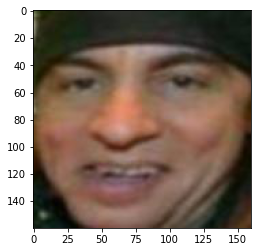

In [ ]:
plot_image(data[330][1])

In [ ]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()

In [ ]:
%%time 
advs_embeddings = get_embddings(advs.cpu())
torch.save(advs_embeddings, 'Dataset/Untiattck_embeddings/unti_pgd_005_embedding_gaus3_sigmax3.pt')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until



CPU times: user 17min 13s, sys: 27 s, total: 17min 40s
Wall time: 17min 40s


In [ ]:
embeddings = torch.load('Dataset/pair_embeddings.pt')
advs_embeddings_003  = torch.load('Dataset/embedding_pair_fgsm_003.pt')
advs_embeddings_004 = torch.load('Dataset/embedding_pair_fgsm_004.pt')
advs_embdding_pgd_004 = torch.load('/content/drive/My Drive/ВКР/Dataset/embedding_pair_pgd_004.pt')
advs_embdding_pgd_005 = torch.load('/content/drive/My Drive/ВКР/Dataset/embedding_pair_pgd_005.pt')
advs_embeddings = torch.load('Dataset/unti_pgd_005_embedding_gaus5.pt')


In [ ]:
def get_distances(advs_embeddings):
  D_1_0 =[]
  D_0_1 = []
  for i in range(len(advs_embeddings)):
    d  = 1 - cosine(advs_embeddings[i][0],embeddings[i][1])
    D_1_0.append(d)
    d =1- cosine(embeddings[i][0],advs_embeddings[i][1])
    D_0_1.append(d)
  return(D_1_0+D_0_1)

In [ ]:

D = get_cosin_dists(embeddings)

D_pgd_005 = D + get_distances(advs_embdding_pgd_005.cpu())
D_FGSM_003 = D + get_distances(advs_embeddings_003.cpu())
D_FGSM_004 = D + get_distances(advs_embeddings_004.cpu())
D_PGD_004 = D+ get_distances(advs_embdding_pgd_004.cpu())
D_gaus = D+get_distances(advs_embeddings.cpu())
labels=labels*3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
%matplotlib inline

%config InlineBackend.figure_format = 'svg'


97.96
96.85
96.44
87.93
86.97
95.67


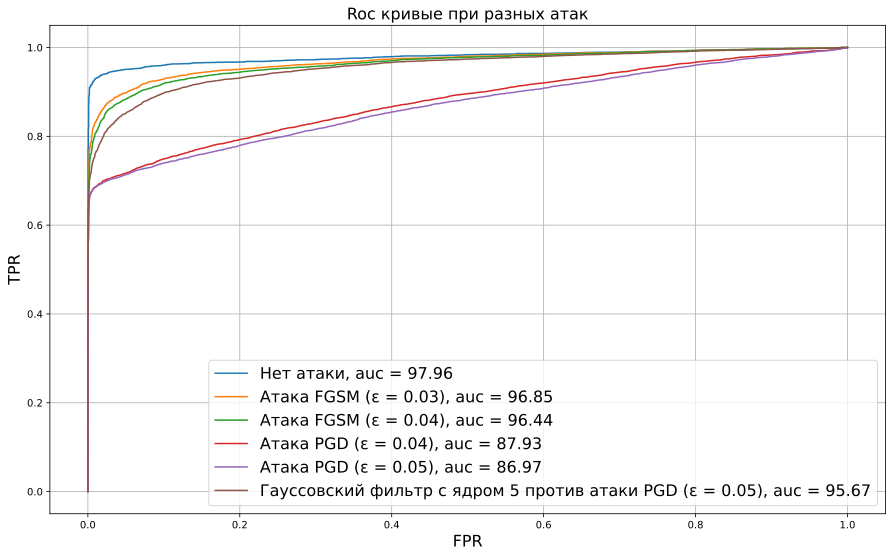

In [ ]:
fig  = plt.figure(figsize=(15,9))
for ds,y in [(D,labels[:6000]), (D_FGSM_003, labels), 
             (D_FGSM_004,labels),(D_PGD_004, labels),
             (D_pgd_005, labels),
             (D_gaus, labels)
             ]:
  fpr, tpr, thresholds = metrics.roc_curve(y, ds, pos_label=1)
  auc = 100 * metrics.auc(fpr, tpr)
  auc = round(auc,2)
  print(auc)
  plt.plot(fpr,tpr)
  plt.xlabel('FPR',fontdict={'fontsize':16})
  plt.ylabel('TPR',fontdict={'fontsize':16})
  plt.title('Roc кривые при разных атак',fontdict={'fontsize':16})
  plt.legend([f'Нет атаки, auc = {97.96}',
              f'Атака FGSM (ε = 0.03), auc = {96.85}',
              f'Атака FGSM (ε = 0.04), auc = {96.44}',
              f'Атака PGD (ε = 0.04), auc = {87.93}',  
              f'Атака PGD (ε = 0.05), auc = {86.97}', 
              f'Гауссовский фильтр с ядром 5 против атаки PGD (ε = 0.05), auc = {95.67}'           
              ],prop={'size': 16}
             )
plt.grid()
plt.show()

In [ ]:
fig.savefig(r'/content/a.png')

## против атак Gaussian

In [ ]:
gaus_d = np.load(r'/content/drive/My Drive/ВКР/Dataset/unti_pgd005_gaus7_sigmax5_pairs.npz')['arr_0']
pgd_005 =np.load(r'/content/drive/My Drive/ВКР/Dataset/adv_pgd005_data.npz')['arr_0']
data =np.load(r'/content/drive/My Drive/ВКР/Dataset/lfw_pairs.npz')['arr_0']

In [ ]:
gaus_d.shape

(10, 2, 3, 160, 160)

In [ ]:
gaus_d = torch.tensor(gaus_d.reshape(20,3,160,160))
pgd_005 = torch.tensor(pgd_005.reshape(20,3,160,160))
data = torch.tensor(data.reshape(12000,3,160,160))[:20]

In [ ]:
pgd_005.shape

torch.Size([20, 3, 160, 160])

In [ ]:
data.shape

torch.Size([20, 3, 160, 160])

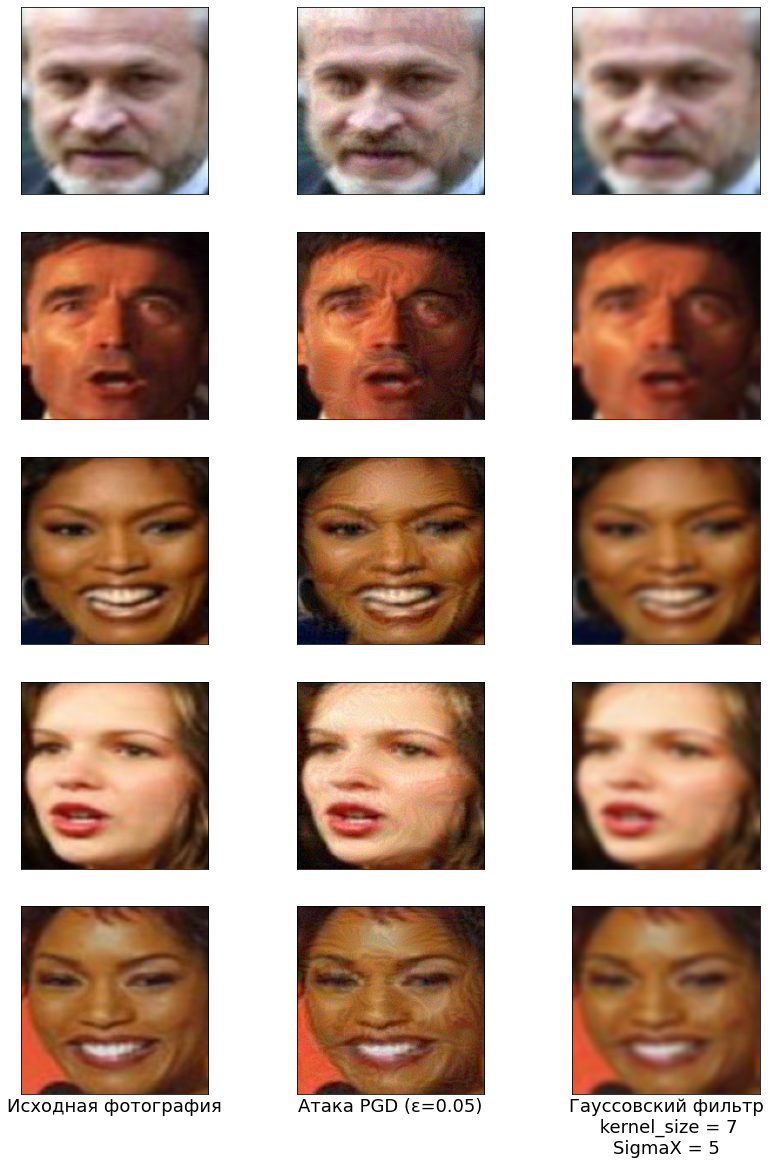

In [ ]:
fig = plt.figure(figsize=(14,20))#1420
plt.text(10,0,'hello',fontsize=14)

j=0
for i in [4,8,12,6,15]:#range(0,20,4):
  # plt.subplots_adjust(hspace=0.01,wspace=0)
  
  j+=1
  plt.subplot(5,3,j)
  plot_image(data[i])
  if i ==15:
    plt.xlabel('Исходная фотография',fontsize=18)
  plt.xticks([])
  plt.yticks([])
  j+=1
  plt.subplot(5,3,j)
  plot_image(pgd_005[i])
  if i==15:
      plt.xlabel('Атака PGD (ε=0.05)',fontsize=18)
  plt.xticks([])
  plt.yticks([])
  j+=1
  plt.subplot(5,3,j)
  plot_image(gaus_d[i])
  if i==15:
    plt.xlabel('Гауссовский фильтр\n kernel_size = 7\nSigmaX = 5',fontsize=18)
  plt.xticks([])
  plt.yticks([])


In [ ]:
fig.savefig('/content/a.png')